In [1]:
import os
import math

from pathlib import Path
from preprocess import *

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.data.experimental import save
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, models

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Download the speech commands dataset if not already downloaded.

In [2]:
data_dir = download_speech_dataset(pathlib.Path("data/"))

In [3]:
command_dirs = tuple(filter(Path.is_dir, pathlib.Path(data_dir).iterdir()))
commands = [p.name for p in command_dirs]
commands.sort()

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
np.random.shuffle(filenames)
print(f"Number of samples: {len(filenames)}\n"
      f"Samples per label: {sum(map(lambda _: 1, command_dirs[0].iterdir()))}")

Number of samples: 8000
Samples per label: 1000


Split data into:

- train
- validation
- test

sets.

In [5]:
splits = split_train_test_validate(filenames)

print("Train, val, test sizes = ", 
      ",".join(map(str,map(len, [splits[0], splits[2], splits[1]]))))

Train, val, test sizes =  6400,800,800


Preprocess data in order to generate STFT spectrograms from the audio samples,
and do batching of input data.

In [6]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

train_ds, val_ds, test_ds = tuple(
    map(lambda files: preprocess_dataset(files, commands), splits))

input_shape = next(iter(map(lambda t: t[0].shape, train_ds.take(1))))

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Define the current model for audio recognition.

Basic CNN model that runs on spectrogram images.

In [7]:
num_labels = len(commands)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

Compile the model and target for accuracy.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model.

In [9]:
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
400/400 [==============================] - 7s 8ms/step - loss: 1.8632 - accuracy: 0.3062 - val_loss: 1.0577 - val_accuracy: 0.6500
Epoch 2/20
400/400 [==============================] - 3s 7ms/step - loss: 1.1109 - accuracy: 0.6119 - val_loss: 0.7811 - val_accuracy: 0.7325
Epoch 3/20
400/400 [==============================] - 3s 8ms/step - loss: 0.8101 - accuracy: 0.7145 - val_loss: 0.6457 - val_accuracy: 0.7987
Epoch 4/20
400/400 [==============================] - 3s 7ms/step - loss: 0.6367 - accuracy: 0.7761 - val_loss: 0.5564 - val_accuracy: 0.8213
Epoch 5/20
400/400 [==============================] - 3s 7ms/step - loss: 0.5277 - accuracy: 0.8096 - val_loss: 0.5385 - val_accuracy: 0.8325
Epoch 6/20
400/400 [==============================] - 3s 8ms/step - loss: 0.4569 - accuracy: 0.8407 - val_loss: 0.5228 - val_accuracy: 0.8313
Epoch 7/20
400/400 [==============================] - 3s 8ms/step - loss: 0.4022 - accuracy: 0.8510 - val_loss: 0.4853 - val_accuracy: 0.8425
Epoch 

Visualize accuracy against epoch number.

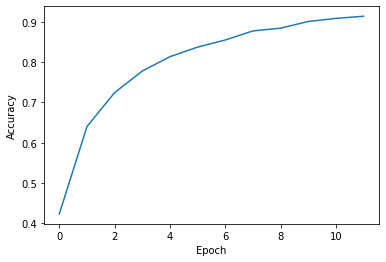

In [10]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Run predictions on the test data.

In [11]:
test_audio = np.zeros([len(splits[1])] + input_shape.as_list(), 
                      dtype=np.float32)
test_labels = np.zeros([len(splits[1])], dtype=np.int)

for i, (audio, label) in enumerate(test_ds.as_numpy_iterator()):
    test_audio[i] = audio
    test_labels[i] = label

Obtain accuracy of the model on the test data.

In [12]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = np.sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 86%


Plot the confusion matrix.

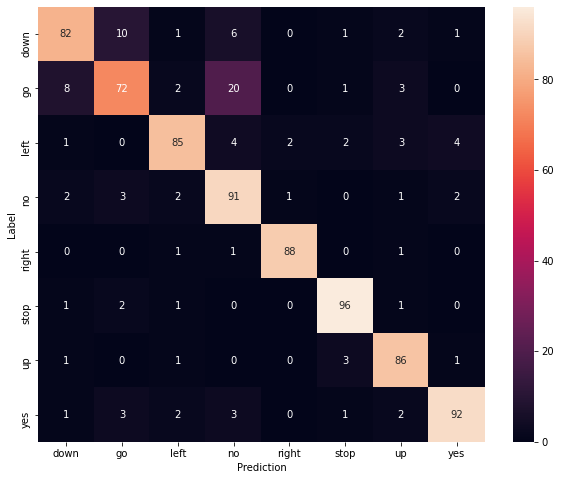

In [13]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Save the model so that it can be used for inference on the cloud.

In [16]:
model_path = pathlib.Path("saved/audiorecog")
if not (model_path_parent := model_path.parent).exists():
    model_path_parent.mkdir(parents=True)
model.save(model_path)

INFO:tensorflow:Assets written to: saved/audiorecog/assets


Save the validation data so that it can be reused for training on the cloud.

In [18]:
validation_data_path = pathlib.Path("saved/validation")
save(val_ds, str(validation_data_path))